# SRE ReAct Agent

This SRE agent uses **LangGraph** to autonomously investigate Kubernetes cluster issues. It connects to a **Model Context Protocol (MCP) server** for Kubernetes access, allowing an **LLM (GPT-5 mini)** to use kubectl commands as tools. The agent follows a **ReAct pattern** (Reason + Act) - it analyzes the hotel reservation service, calls K8s tools when needed, and provides diagnostic reports without human intervention.

**Key components:**
- **MCP Client**: Provides kubectl tools to the LLM
- **LangGraph**: Orchestrates the investigation workflow  
- **ReAct Loop**: Agent → Tools → Agent until diagnosis complete

The agent automatically starts investigating when triggered by the system prompt.

In [46]:
from dotenv import load_dotenv
import os
load_dotenv()

True

In [47]:
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI

gpt5 = ChatOpenAI(model="gpt-5")
gpt5mini = ChatOpenAI(model="gpt-5-mini")
gemini = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    google_api_key=os.getenv("GOOGLEAI_API_KEY") # Google AI Studio free api key
)

## Testing MCP Client for Kubernetes

MCP K8s server: [mcp-server-kubernetes](https://github.com/Flux159/mcp-server-kubernetes)

In [48]:
from langchain_mcp_adapters.client import MultiServerMCPClient

client = MultiServerMCPClient(
    {
        "kubernetes" : {
            "command": "npx",
            "args": ["mcp-server-kubernetes"],
            "transport": "stdio",
            "env": {
                "ALLOW_ONLY_NON_DESTRUCTIVE_TOOLS": "true"
            }
        }
    }
)

# NB: The cluster has to be running otherwise the tools won't be available
mcp_tools = await client.get_tools()

In [49]:
#list all the tools
for tool in mcp_tools:
    print(f"🔧 {tool.name}: {tool.description}")

🔧 kubectl_get: Get or list Kubernetes resources by resource type, name, and optionally namespace
🔧 kubectl_describe: Describe Kubernetes resources by resource type, name, and optionally namespace
🔧 kubectl_apply: Apply a Kubernetes YAML manifest from a string or file
🔧 kubectl_create: Create Kubernetes resources using various methods (from file or using subcommands)
🔧 kubectl_logs: Get logs from Kubernetes resources like pods, deployments, or jobs
🔧 kubectl_scale: Scale a Kubernetes deployment
🔧 kubectl_patch: Update field(s) of a resource using strategic merge patch, JSON merge patch, or JSON patch
🔧 kubectl_rollout: Manage the rollout of a resource (e.g., deployment, daemonset, statefulset)
🔧 kubectl_context: Manage Kubernetes contexts - list, get, or set the current context
🔧 explain_resource: Get documentation for a Kubernetes resource or field
🔧 install_helm_chart: Install a Helm chart
🔧 upgrade_helm_chart: Upgrade a Helm release
🔧 port_forward: Forward a local port to a port on a

In [50]:
# Tools allowed
tools_allowed = ["kubectl_get", "kubectl_describe", "kubectl_logs", "explain_resource", "list_api_resources", "ping"]

tools = []
for tool in mcp_tools:
    if tool.name in tools_allowed:
        tools.append(tool)


In [51]:
for tool in tools:
    print(f"🔧 {tool.name}: {tool.description}")

🔧 kubectl_get: Get or list Kubernetes resources by resource type, name, and optionally namespace
🔧 kubectl_describe: Describe Kubernetes resources by resource type, name, and optionally namespace
🔧 kubectl_logs: Get logs from Kubernetes resources like pods, deployments, or jobs
🔧 explain_resource: Get documentation for a Kubernetes resource or field
🔧 list_api_resources: List the API resources available in the cluster
🔧 ping: Verify that the counterpart is still responsive and the connection is alive.


## Baseline model

All the previous messages are passed to the LLM for determining the next action

This implementation requires a lot of tokens

In [52]:
sytem_prompt = """
    You are an expert DevOps engineer who has been tasked with detecting anomalies in a deployed service.

    The service you are working with today is described below:
    {app_summary}

    You will use an MCP server which will provide you access to the kubernetes cluster.

    You will begin by analyzing the service's state and telemetry, and then submit your solution: describe the issue you have identified without fixing it!
    Also explain your reasoning and thought process behind the solution.
    Do not add any followup questions nor additional context.
    """

app_summary = """
    The application implements a hotel reservation service, build with Go and gRPC, and starting from the open-source project https://github.com/harlow/go-micro-services. The initial project is extended in several ways, including adding back-end in-memory and persistent databases, adding a recommender system for obtaining hotel recommendations, and adding the functionality to place a hotel reservation. 
"""

In [53]:
llm_with_tools = gpt5mini.bind_tools(tools, parallel_tool_calls=False)

from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content=sytem_prompt.format(app_summary=app_summary))

# Node
async def sreAgent(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

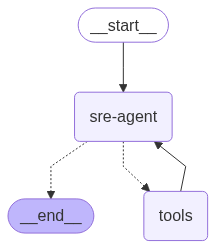

In [54]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("sre-agent", sreAgent)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "sre-agent")
builder.add_conditional_edges(
    "sre-agent",
    # If the latest message (result) from sre-agent is a tool call -> tools_condition routes to tools
    # If the latest message (result) from sre-agent is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "sre-agent")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [55]:
import time

async def test_async_graph(graph , human_message: str, trace_name: str = None):
    """Test the graph with proper async execution"""
    # Create a human message from the input
    messages = [HumanMessage(content=human_message)]
    
    # Start time tracking
    start_time = time.time()

    # Configuration for the graph execution
    config = {"recursion_limit": 50}
    if trace_name:
        config["run_name"] = trace_name
    
    # Invoke the graph asynchronously
    result = await graph.ainvoke({"messages": messages}, config)

    # Calculate execution time
    execution_time = time.time() - start_time
    
    # Print results
    for m in result['messages']:
        m.pretty_print()
    
    # Calculate token usage
    total_tokens = 0
    input_tokens = 0
    output_tokens = 0
    
    for m in result['messages']:
        if hasattr(m, 'usage_metadata'):
            if m.usage_metadata:
                if 'input_tokens' in m.usage_metadata:
                    input_tokens += m.usage_metadata['input_tokens']
                if 'output_tokens' in m.usage_metadata:
                    output_tokens += m.usage_metadata['output_tokens']
                if 'total_tokens' in m.usage_metadata:
                    total_tokens += m.usage_metadata['total_tokens']

    result["total_tokens"] = total_tokens
    result["input_tokens"] = input_tokens
    result["output_tokens"] = output_tokens
    result["execution_time"] = execution_time
    
    print(f"\nExecution time: {execution_time:.2f} seconds")
    print(f"Token usage: {total_tokens} total ({input_tokens} input, {output_tokens} output)")
    
    return result

In [56]:
experiment_name = input("Enter experiment name: ")

if experiment_name.strip() == "":
    experiment_name = "SRE ReAct agent"

In [57]:
human = ""

result_baseline = await test_async_graph(react_graph, human, trace_name=experiment_name)

================================ Human Message =================================


================================== Ai Message ==================================
Tool Calls:
  kubectl_get (call_SIzOIEOdrFNADYtmWqW4o4MK)
 Call ID: call_SIzOIEOdrFNADYtmWqW4o4MK
  Args:
    resourceType: pods
    name: 
    namespace: default
    allNamespaces: True
    output: wide
================================= Tool Message =================================
Name: kubectl_get

NAMESPACE                NAME                                                       READY   STATUS             RESTARTS        AGE   IP            NODE                 NOMINATED NODE   READINESS GATES
default                  wrk2-job-ckmtv                                             0/1     Completed          0               22m   10.244.1.52   kind-worker          <none>           <none>
kube-system              coredns-668d6bf9bc-66rlq                                   1/1     Running            0               40m   10.244

In [58]:
# Final AI response
result_baseline["messages"][-1].pretty_print()

================================== Ai Message ==================================

Summary of the issue
- The geo service (pod geo-...) is CrashLoopBackOff because it cannot start: its container repeatedly exits with Exit Code 2 and is being restarted by kubelet.
- Root cause (most likely): the geo service is configured to connect to MongoDB on mongodb-geo:27777, but the mongodb-geo service is exposing MongoDB on port 27017. This port mismatch prevents geo from establishing a DB connection at startup and causes the process to exit.

Evidence and reasoning (what I checked and why)
1. Cluster pod status
   - I listed pods across namespaces and found the geo pod in namespace test-hotel-reservation in CrashLoopBackOff:
     - Pod: test-hotel-reservation/geo-6b4b89b5f5-2hrmm
     - Status: CrashLoopBackOff, Restart Count: 9
   - This indicates the container process repeatedly fails soon after starting.

2. Pod description (kubectl describe pod)
   - describe shows the container's Last State:

In [59]:
import os
import datetime
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage

def saveExperiment(experiment_name, result):
    
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

    results_folder = "results"
    os.makedirs(results_folder, exist_ok=True)

    # Create the full path for the file
    file_path = os.path.join(results_folder, f"{timestamp}.txt")

    # Format and write messages to file
    with open(file_path, 'w') as f:
        f.write(f"{'='*50}\nEXPERIMENT SUMMARY\n{'='*50}\n\n")
        if experiment_name:
            f.write(f"Experiment Name: {experiment_name}\n")
        f.write(f"Total tokens used: {result['total_tokens']}\n")
        f.write(f"Input tokens: {result['input_tokens']}\n")
        f.write(f"Output tokens: {result['output_tokens']}\n")
        f.write(f"Execution time: {result['execution_time']:.2f} seconds\n\n")

        f.write(f"{'='*50}\nSYSTEM PROMPT\n{'='*50}\n\n")
        f.write(sys_msg.content + "\n\n")
        

        for i, message in enumerate(result['messages']):
            f.write(f"{'='*50}\nMESSAGE {i+1}\n{'='*50}\n")
            
            if isinstance(message, HumanMessage):
                f.write(f"Type: Human Message\n")
                f.write(f"Content: {message.content}\n\n")
            
            elif isinstance(message, AIMessage):
                f.write(f"Type: AI Message\n")
                if message.content:
                    f.write(f"Content: {message.content}\n\n")
                
                if hasattr(message, 'additional_kwargs') and 'tool_calls' in message.additional_kwargs:
                    tool_calls = message.additional_kwargs['tool_calls']
                    f.write(f"Tool Calls ({len(tool_calls)}):\n")
                    
                    for idx, tool_call in enumerate(tool_calls):
                        f.write(f"  Tool Call {idx+1}: {tool_call['id']}\n")
                        if 'function' in tool_call:
                            f.write(f"    Function: {tool_call['function']['name']}\n")
                            f.write(f"    Arguments: {tool_call['function']['arguments']}\n\n")
            
            elif isinstance(message, ToolMessage):
                f.write(f"Type: Tool Response\n")
                f.write(f"Tool Call ID: {message.tool_call_id}\n")
                f.write(f"Content:\n{message.content}\n\n")
            
            else:
                f.write(f"Type: Other Message Type ({type(message).__name__})\n")
                f.write(f"Content: {str(message)}\n\n")

    print(f"Messages exported to {file_path}")

In [60]:
saveExperiment(experiment_name, result_baseline)

Messages exported to results/20250820_102946.txt


# Improve agent efficiency (in terms of tokens)

## Reduce context by passing only three messages

In [71]:
MAX_MESSAGES = 7

In [74]:
system_prompt_reduced_input = """
You are an expert DevOps engineer who has been tasked with detecting anomalies in a deployed service.

The service you are working with today is described below:
{app_summary}

Important constraint:
You only have access to the {max_messages} most recent messages in this conversation. 
Anything older is not visible to you, so do not reference or assume context beyond those last 5 messages.

Your task:
- Begin by analyzing the service's state and telemetry.
- Then submit your solution: describe the issue you have identified (without fixing it).
- Also explain your reasoning and thought process.
- Do not add any followup questions nor additional context.
"""

app_summary = """
    The application implements a hotel reservation service, build with Go and gRPC, and starting from the open-source project https://github.com/harlow/go-micro-services. The initial project is extended in several ways, including adding back-end in-memory and persistent databases, adding a recommender system for obtaining hotel recommendations, and adding the functionality to place a hotel reservation. 
"""

In [75]:
llm_with_tools = gpt5mini.bind_tools(tools, parallel_tool_calls=False)

from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg_reduced = SystemMessage(content=system_prompt_reduced_input.format(app_summary=app_summary, max_messages=MAX_MESSAGES))

# Node which limits the context window 
async def sreAgent_reducedInput(state: MessagesState):

   messages = state["messages"]

   if len(state["messages"]) <= MAX_MESSAGES:
      return {"messages": [llm_with_tools.invoke([sys_msg_reduced] + messages)]}
   
   # Reduce the context window by taking only the last few messages
   context_messages = []

   # Work backwards from the end
   i = len(messages) - 1
   while i >= 0 and len(context_messages) < (MAX_MESSAGES + 2):
      msg = messages[i]
      context_messages.insert(0, msg)
      
      # If this is a ToolMessage, make sure to include the AIMessage that called it
      if isinstance(msg, ToolMessage) and i > 0:
         prev_msg = messages[i-1]
         if isinstance(prev_msg, AIMessage) and hasattr(prev_msg, 'additional_kwargs'):
               if 'tool_calls' in prev_msg.additional_kwargs and prev_msg not in context_messages:
                  context_messages.insert(0, prev_msg)
      i -= 1

      return {"messages": [llm_with_tools.invoke([sys_msg_reduced] + context_messages)]}




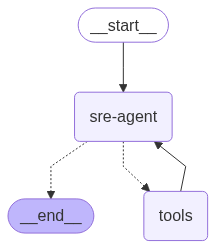

In [76]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("sre-agent", sreAgent_reducedInput)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "sre-agent")
builder.add_conditional_edges(
    "sre-agent",
    # If the latest message (result) from sre-agent is a tool call -> tools_condition routes to tools
    # If the latest message (result) from sre-agent is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "sre-agent")
react_graph_reduced = builder.compile()

# Show
display(Image(react_graph_reduced.get_graph(xray=True).draw_mermaid_png()))

In [77]:
experiment_name = input("Enter experiment name: ")

if experiment_name.strip() == "":
    experiment_name = "SRE ReAct agent"

In [78]:
human = ""

result_reduced = await test_async_graph(react_graph_reduced, human, trace_name=experiment_name)

================================ Human Message =================================


================================== Ai Message ==================================
Tool Calls:
  kubectl_get (call_MN0jy3Cp1ImnHSKnoL5aq9fP)
 Call ID: call_MN0jy3Cp1ImnHSKnoL5aq9fP
  Args:
    resourceType: pods
    name: 
    namespace: default
    allNamespaces: True
    output: wide
================================= Tool Message =================================
Name: kubectl_get

NAMESPACE                NAME                                                       READY   STATUS             RESTARTS       AGE   IP            NODE                 NOMINATED NODE   READINESS GATES
default                  wrk2-job-ckmtv                                             0/1     Completed          0              39m   10.244.1.52   kind-worker          <none>           <none>
kube-system              coredns-668d6bf9bc-66rlq                                   1/1     Running            0              57m   10.244.0.

In [79]:
# Final AI answer
result_reduced["messages"][-1].pretty_print()

================================== Ai Message ==================================

Summary
- The geo microservice is repeatedly crashing on startup because it cannot connect to its MongoDB backend. The pod log shows a panic with the message "no reachable servers" when attempting to initialize the DB connection to mongodb-geo:27777.

Evidence (from pod geo-6b4b89b5f5-2hrmm, namespace test-hotel-reservation)
- Config and attempt to connect:
  - "Read database URL: mongodb-geo:27777"
  - "Initializing DB connection..."
- Error and panic:
  - "no reachable servers"
  - Stack trace ends in main.initializeDatabase -> panic

Observed service state / telemetry interpretation
- The geo service starts, reads configuration, and immediately tries to connect to MongoDB.
- The mgo driver (MongoDB Go driver used here) emits "no reachable servers" when it cannot connect to any configured MongoDB hosts. The code then logs and panics, causing the container to terminate.
- Because the process panics durin

In [80]:
saveExperiment(experiment_name, result_reduced)

Messages exported to results/20250820_104615.txt
